In [ ]:
import os
from glob import glob
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score
from tqdm import tqdm
from torchmetrics.classification import ConfusionMatrix
import time
import seaborn as sns

In [ ]:
import os
images_list = glob("RafDDownload-C5812604F538F8BB73985B0C529BAFA1/*.jpg")

In [ ]:
data = []
for filename in images_list:
    parts = filename.split('_')
    race = parts[2]
    gender = parts[3]
    emotion = parts[4]
    orientation = parts[5].split('.')[0]  # Remove the file extension
    data.append([filename, race, gender, emotion, orientation])

# Creating DataFrame
df = pd.DataFrame(data, columns=["Filename", "Race", "Gender", "Emotion", "Orientation"])


In [ ]:
df['Emotion'].value_counts()

Emotion
angry           585
sad             585
disgusted       585
contemptuous    585
surprised       585
happy           585
neutral         585
fearful         585
Name: count, dtype: int64

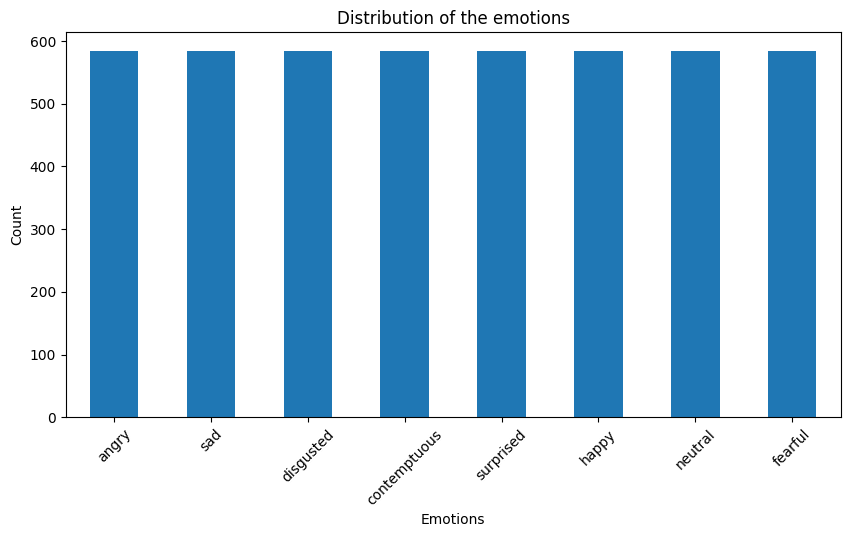

In [ ]:
# Plot the bar chart with custom colors
plt.figure(figsize=(10, 5))
df['Emotion'].value_counts().plot(kind='bar')
plt.title('Distribution of the emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df[['Filename', 'Emotion']].to_csv('RafD_labels.csv', index=False)

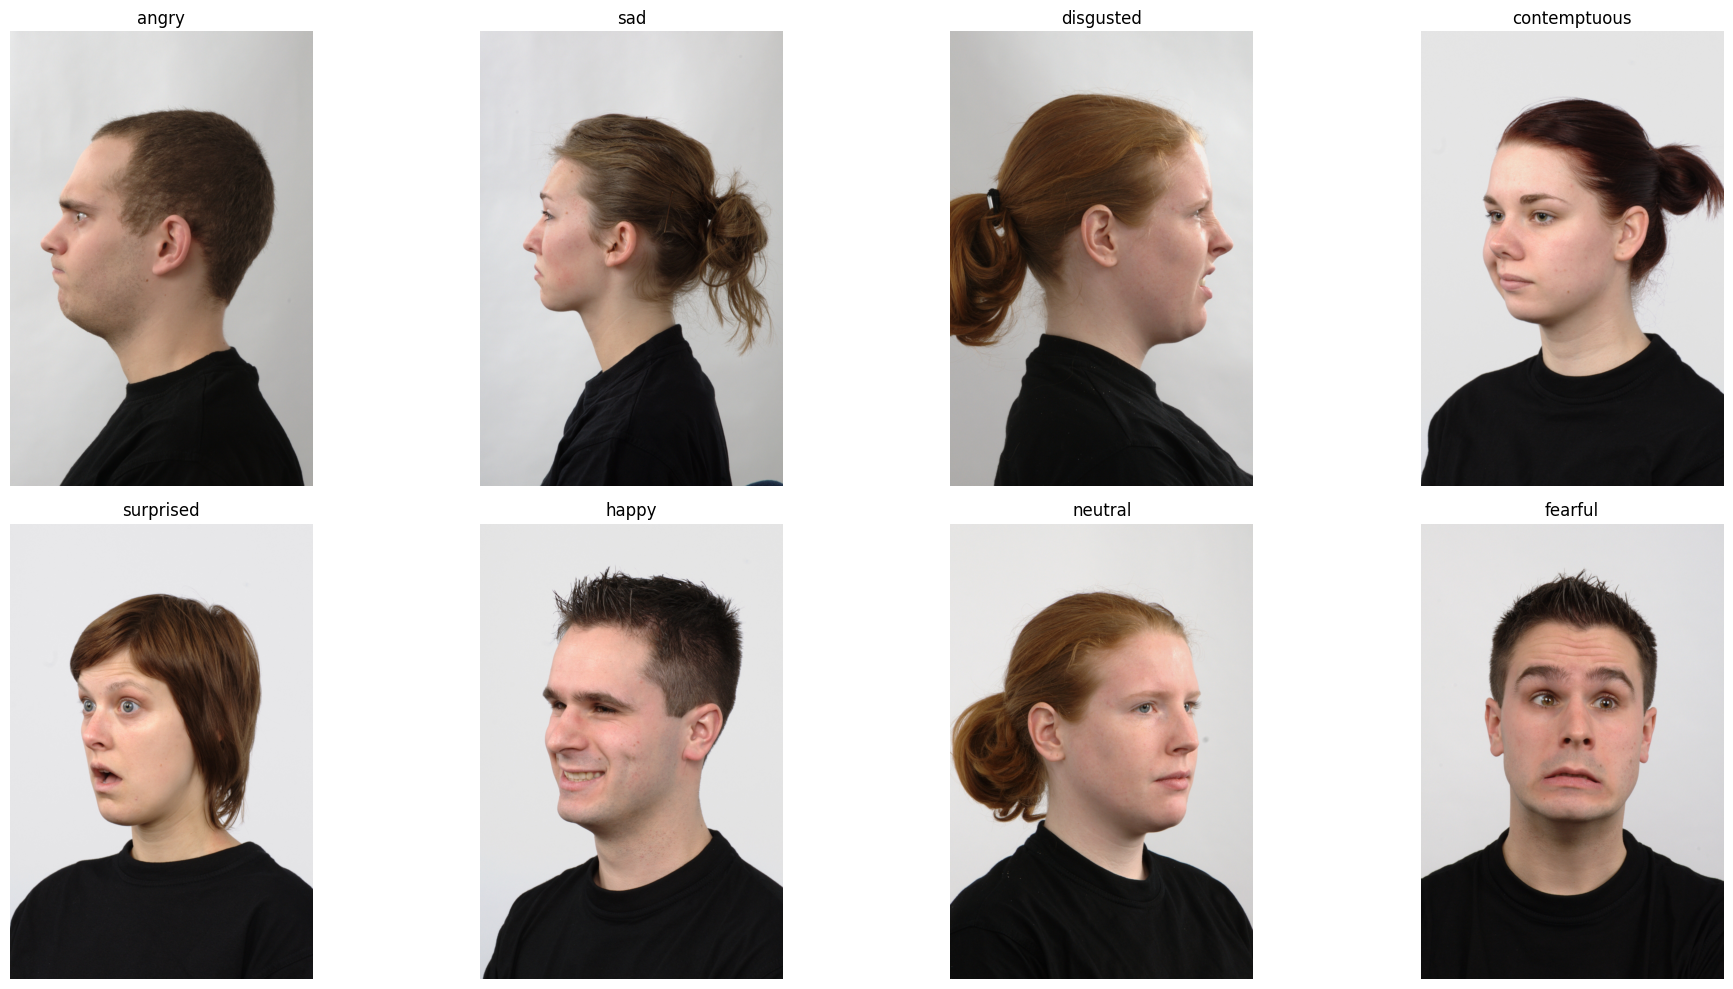

In [ ]:
emotion_examples = {}

# Iterate over each emotion and get one example
for emotion in df['Emotion'].unique():
    emotion_examples[emotion] = df[df['Emotion'] == emotion]['Filename'].iloc[0]

# Plot the example images
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for ax, (emotion, path) in zip(axes, emotion_examples.items()):
    image = Image.open(path)
    ax.imshow(image)
    ax.set_title(emotion)
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

### Prepare test and train data

In [ ]:
print(df.shape)

(4680, 5)


In [ ]:
test_df = df[df['Filename'].str.contains("05_Caucasian_male")].reset_index(drop=True)
print(test_df.shape)
test_df.head()

(120, 5)


,Filename,Race,Gender,Emotion,Orientation
0,RafDDownload-C5812604F538F8BB73985B0C529BAFA1/...,Caucasian,male,neutral,left
1,RafDDownload-C5812604F538F8BB73985B0C529BAFA1/...,Caucasian,male,sad,left
2,RafDDownload-C5812604F538F8BB73985B0C529BAFA1/...,Caucasian,male,angry,left
3,RafDDownload-C5812604F538F8BB73985B0C529BAFA1/...,Caucasian,male,contemptuous,frontal
4,RafDDownload-C5812604F538F8BB73985B0C529BAFA1/...,Caucasian,male,surprised,frontal


In [ ]:
test_df['Orientation'].value_counts()

Orientation
left       40
frontal    40
right      40
Name: count, dtype: int64

In [ ]:
test_df['Emotion'].value_counts()

Emotion
neutral         15
sad             15
angry           15
contemptuous    15
surprised       15
fearful         15
disgusted       15
happy           15
Name: count, dtype: int64

In [ ]:
df = df[~(df['Filename'].str.contains("05_Caucasian_male"))].reset_index(drop=True)

In [ ]:
df.shape

(4560, 5)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {
            'angry': 0,
            'sad': 1,
            'disgusted': 2,
            'contemptuous': 3,
            'surprised': 4,
            'happy': 5,
            'neutral': 6,
            'fearful': 7
        }

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.annotations.iloc[idx, 1]
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)


In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

# Load the dataset
dataset = EmotionDataset(csv_file='RafD_labels.csv', root_dir='.', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNeXt50_32X4D_Weights

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=8):
        super(CNNModel, self).__init__()

        # Load the pre-trained VGG16 model
        self.model = models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights)
        #self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)


    def forward(self, x):
        return self.model(x)

In [ ]:
num_classes = 8

In [ ]:
model = CNNModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Users/chinmay/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
if torch.backends.mps.is_available():
    print("MPS backend is available.")
else:
    print("MPS backend is not available.")

MPS backend is available.


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, monitor='accuracy', path='checkpoint.pt'):
        self.patience = patience
        self.monitor = monitor
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, monitor, model):
        if self.best_score is None:
            self.best_score = monitor
            self.save_checkpoint(model)
        elif monitor < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = monitor
            self.counter = 0
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        '''Saves the model when the monitored metric improves.'''
        torch.save(model.state_dict(), self.path)
        print(f'Model saved to {self.path}')

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    accuracy = Accuracy(task='multiclass',num_classes = num_classes).to(device)
    precision = Precision(task='multiclass',average='macro', num_classes = num_classes).to(device)
    recall = Recall(task='multiclass',average='macro', num_classes = num_classes).to(device)
    f1 = F1Score(task='multiclass',average='macro', num_classes = num_classes).to(device)

    for images, emotions in tqdm(loader):
        images, emotions = images.to(device), emotions.to(device)

        optimizer.zero_grad()

        outputs_intensity = model(images).squeeze()

        loss_emotion = criterion(outputs_intensity, emotions)

        loss = loss_emotion
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs_intensity, dim=1)

        accuracy.update(preds, emotions)
        precision.update(preds, emotions)
        recall.update(preds, emotions)
        f1.update(preds, emotions)

    avg_loss = running_loss / len(loader)
    acc = accuracy.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    f1_score = f1.compute().item()

    # Reset metrics for the next epoch
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

    return avg_loss, acc, prec, rec, f1_score

In [ ]:
def validate(model, loader, criterion, device, confusion_matrix_=False):
    model.eval()
    running_loss = 0.0
    val_accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
    val_precision = Precision(task='multiclass', average='macro', num_classes=num_classes).to(device)
    val_recall = Recall(task='multiclass', average='macro', num_classes=num_classes).to(device)
    val_f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes).to(device)


    output_list = []
    target_list = []

    with torch.no_grad():
        for images, emotions in loader:
            images, emotions = images.to(device), emotions.to(device)

            outputs_intensity = model(images).squeeze()

            loss_emotion = criterion(outputs_intensity, emotions)

            loss = loss_emotion
            running_loss += loss.item()

            preds = torch.argmax(outputs_intensity, dim=1)

            val_accuracy.update(preds, emotions)
            val_precision.update(preds, emotions)
            val_recall.update(preds, emotions)
            val_f1.update(preds, emotions)

            target_list.append(emotions)
            output_list.append(preds)

    avg_loss = running_loss / len(loader)
    acc = val_accuracy.compute().item()
    prec = val_precision.compute().item()
    rec = val_recall.compute().item()
    f1_score = val_f1.compute().item()

    # Reset metrics for the next epoch
    val_accuracy.reset()
    val_precision.reset()
    val_recall.reset()
    val_f1.reset()

    if confusion_matrix_:
        bcm = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
        confusion_matrix_score = bcm(torch.cat(output_list), torch.cat(target_list))
        return avg_loss, acc, prec, rec, f1_score, confusion_matrix_score
    return avg_loss, acc, prec, rec, f1_score

In [ ]:
# Training loop
num_epochs = 30

patience = 5
early_stopping = EarlyStopping(patience=5, delta=0, monitor='val_accuracy', path='best_model_emotion.pt')

start_time = 0
end_time = 0
training_losses = []
validation_losses = []

training_accuracies = []
validation_accuracies = []

training_f1_scores = []
validation_f1_scores = []

training_precisions = []
validation_precisions = []

for epoch in range(num_epochs):
    print('epoch starts:', epoch)
    start_time = time.time()
    train_loss, train_acc, train_prec, train_rec, train_f1_score = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_prec, val_rec, val_f1_score = validate(model, val_loader, criterion, device)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    training_f1_scores.append(train_f1_score)
    validation_f1_scores.append(val_f1_score)

    training_precisions.append(train_prec)
    validation_precisions.append(val_prec)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train Prec: {train_prec:.4f} | Train Rec: {train_rec:.4f} | Train F1: {train_f1_score:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Prec: {val_prec:.4f} | Val Rec: {val_rec:.4f} | Val F1: {val_f1_score:.4f}")

    early_stopping(val_acc, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
    end_time = time.time()
    print('time taken for epoch:', (end_time-start_time)/60, 'minutes')

epoch starts: 0


100%|██████████| 117/117 [02:12<00:00,  1.13s/it]


Epoch 1/30
Train Loss: 0.9810 | Train Acc: 0.6146 | Train Prec: 0.6109 | Train Rec: 0.6151 | Train F1: 0.6126
Val Loss: 0.8522 | Val Acc: 0.7009 | Val Prec: 0.7738 | Val Rec: 0.7042 | Val F1: 0.7053
Model saved to best_model_emotion.pt
time taken for epoch: 2.525825568040212 minutes
epoch starts: 1


100%|██████████| 117/117 [02:08<00:00,  1.10s/it]


Epoch 2/30
Train Loss: 0.4830 | Train Acc: 0.8291 | Train Prec: 0.8290 | Train Rec: 0.8293 | Train F1: 0.8290
Val Loss: 0.7902 | Val Acc: 0.7019 | Val Prec: 0.8148 | Val Rec: 0.7009 | Val F1: 0.6981
Model saved to best_model_emotion.pt
time taken for epoch: 2.4476045330365497 minutes
epoch starts: 2


100%|██████████| 117/117 [02:27<00:00,  1.26s/it]


Epoch 3/30
Train Loss: 0.2923 | Train Acc: 0.8966 | Train Prec: 0.8977 | Train Rec: 0.8966 | Train F1: 0.8970
Val Loss: 0.2704 | Val Acc: 0.9145 | Val Prec: 0.9176 | Val Rec: 0.9137 | Val F1: 0.9125
Model saved to best_model_emotion.pt
time taken for epoch: 2.7812514464060465 minutes
epoch starts: 3


100%|██████████| 117/117 [02:07<00:00,  1.09s/it]


Epoch 4/30
Train Loss: 0.3116 | Train Acc: 0.8969 | Train Prec: 0.8973 | Train Rec: 0.8969 | Train F1: 0.8970
Val Loss: 1.4133 | Val Acc: 0.6656 | Val Prec: 0.7626 | Val Rec: 0.6680 | Val F1: 0.6623
EarlyStopping counter: 1 out of 5
time taken for epoch: 2.445973217487335 minutes
epoch starts: 4


100%|██████████| 117/117 [11:06<00:00,  5.70s/it]  


Epoch 5/30
Train Loss: 0.2056 | Train Acc: 0.9311 | Train Prec: 0.9315 | Train Rec: 0.9310 | Train F1: 0.9311
Val Loss: 0.1877 | Val Acc: 0.9295 | Val Prec: 0.9345 | Val Rec: 0.9277 | Val F1: 0.9269
Model saved to best_model_emotion.pt
time taken for epoch: 11.41141486565272 minutes
epoch starts: 5


100%|██████████| 117/117 [02:12<00:00,  1.13s/it]


Epoch 6/30
Train Loss: 0.1708 | Train Acc: 0.9444 | Train Prec: 0.9447 | Train Rec: 0.9445 | Train F1: 0.9446
Val Loss: 0.3787 | Val Acc: 0.8697 | Val Prec: 0.8888 | Val Rec: 0.8689 | Val F1: 0.8701
EarlyStopping counter: 1 out of 5
time taken for epoch: 2.5257171312967936 minutes
epoch starts: 6


100%|██████████| 117/117 [02:13<00:00,  1.14s/it]


Epoch 7/30
Train Loss: 0.1101 | Train Acc: 0.9669 | Train Prec: 0.9669 | Train Rec: 0.9669 | Train F1: 0.9669
Val Loss: 0.0874 | Val Acc: 0.9679 | Val Prec: 0.9687 | Val Rec: 0.9682 | Val F1: 0.9675
Model saved to best_model_emotion.pt
time taken for epoch: 2.5387323180834453 minutes
epoch starts: 7


100%|██████████| 117/117 [02:11<00:00,  1.12s/it]


Epoch 8/30
Train Loss: 0.0804 | Train Acc: 0.9741 | Train Prec: 0.9743 | Train Rec: 0.9741 | Train F1: 0.9741
Val Loss: 0.2081 | Val Acc: 0.9316 | Val Prec: 0.9327 | Val Rec: 0.9297 | Val F1: 0.9283
EarlyStopping counter: 1 out of 5
time taken for epoch: 2.4898080984751383 minutes
epoch starts: 8


100%|██████████| 117/117 [02:11<00:00,  1.12s/it]


Epoch 9/30
Train Loss: 0.0947 | Train Acc: 0.9688 | Train Prec: 0.9689 | Train Rec: 0.9688 | Train F1: 0.9689
Val Loss: 0.1647 | Val Acc: 0.9519 | Val Prec: 0.9531 | Val Rec: 0.9512 | Val F1: 0.9509
EarlyStopping counter: 2 out of 5
time taken for epoch: 2.490854501724243 minutes
epoch starts: 9


100%|██████████| 117/117 [02:10<00:00,  1.12s/it]


Epoch 10/30
Train Loss: 0.1382 | Train Acc: 0.9538 | Train Prec: 0.9539 | Train Rec: 0.9538 | Train F1: 0.9539
Val Loss: 0.5724 | Val Acc: 0.8408 | Val Prec: 0.8958 | Val Rec: 0.8511 | Val F1: 0.8229
EarlyStopping counter: 3 out of 5
time taken for epoch: 2.5005574822425842 minutes
epoch starts: 10


100%|██████████| 117/117 [02:11<00:00,  1.12s/it]


Epoch 11/30
Train Loss: 0.1350 | Train Acc: 0.9565 | Train Prec: 0.9567 | Train Rec: 0.9565 | Train F1: 0.9566
Val Loss: 0.1421 | Val Acc: 0.9615 | Val Prec: 0.9636 | Val Rec: 0.9619 | Val F1: 0.9618
EarlyStopping counter: 4 out of 5
time taken for epoch: 2.4893267154693604 minutes
epoch starts: 11


100%|██████████| 117/117 [02:12<00:00,  1.13s/it]


Epoch 12/30
Train Loss: 0.0695 | Train Acc: 0.9778 | Train Prec: 0.9780 | Train Rec: 0.9779 | Train F1: 0.9779
Val Loss: 0.5420 | Val Acc: 0.8483 | Val Prec: 0.8951 | Val Rec: 0.8505 | Val F1: 0.8438
EarlyStopping counter: 5 out of 5
Early stopping


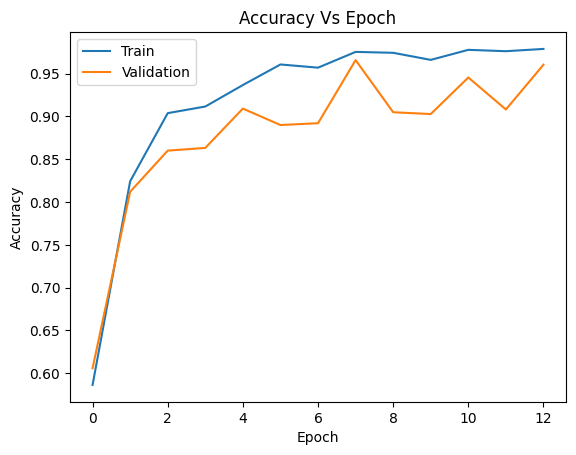

In [ ]:
plt.plot(training_accuracies, label='Train')
plt.plot(validation_accuracies, label='Validation')
plt.title('Accuracy Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

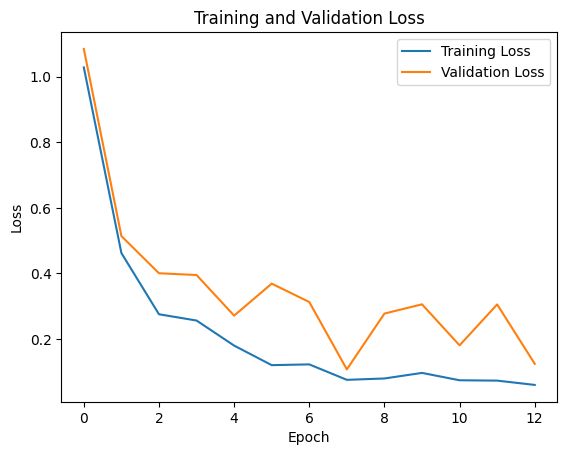

In [ ]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# final evaluation
val_loss, val_acc, val_prec, val_rec, val_f1_score, cf = validate(model, val_loader,
                                                              criterion,
                                                              device, confusion_matrix_=True)
print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f} | Validation Prec: {val_prec:.4f} | Validation Rec: {val_rec:.4f} | Validation F1: {val_f1_score:.4f}")


Validation Loss: 0.1241 | Validation Acc: 0.9605 | Validation Prec: 0.9620 | Validation Rec: 0.9618 | Validation F1: 0.9614


In [ ]:
class_dict = {
            'angry': 0,
            'sad': 1,
            'disgusted': 2,
            'contemptuous': 3,
            'surprised': 4,
            'happy': 5,
            'neutral': 6,
            'fearful': 7
        }


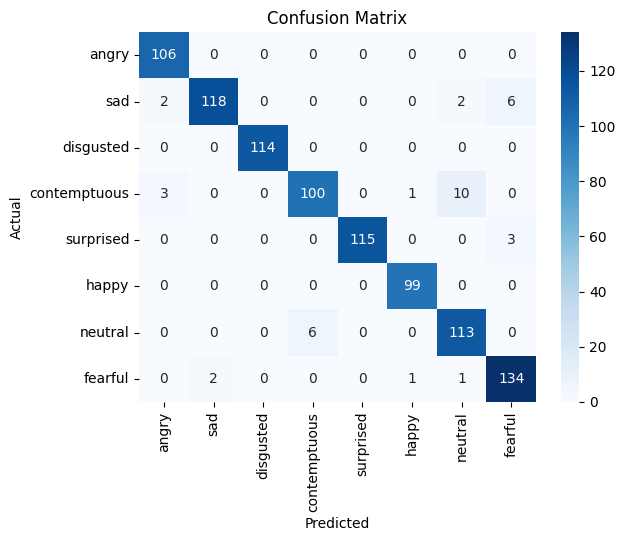

In [ ]:
# Assuming class_dict is a dictionary with class names as keys
class_names = list(class_dict.keys())

cf_matrix = cf.cpu().numpy()
# Create the heatmap with class names
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Prediction for single image

In [ ]:
# get random row in df
random_row = df.sample()
random_row

,Filename,Race,Gender,Emotion,Orientation
1181,RafDDownload-C5812604F538F8BB73985B0C529BAFA1/...,Caucasian,female,disgusted,left


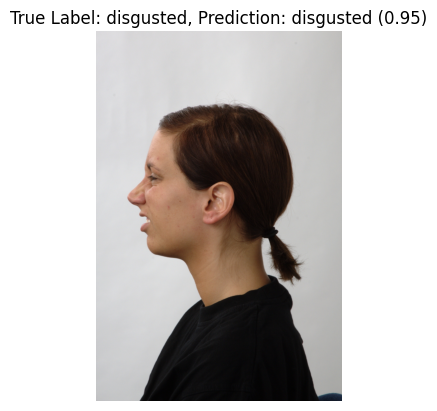

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the class names
class_names = ['angry', 'sad', 'disgusted', 'contemptuous', 'surprised', 'happy', 'neutral', 'fearful']

def predict_single_image(model, image_path, device):
    model.eval()

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_batch).squeeze()
        prediction = torch.softmax(output, dim=0).cpu().numpy()

    predicted_class = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class]

    return predicted_class_name, prediction[predicted_class]

# Function to show the image with true label and prediction
def show_image_with_prediction(image_path, true_label, predicted_label, predicted_prob):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'True Label: {true_label}, Prediction: {predicted_label} ({predicted_prob:.2f})')
    plt.axis('off')
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Replace 'path_to_image' with the actual path to the image
image_path = random_row['Filename'].values[0]
true_label = random_row['Emotion'].values[0]

predicted_label, predicted_prob = predict_single_image(model, image_path, device)
show_image_with_prediction(image_path, true_label, predicted_label, predicted_prob)


In [ ]:
best_model = CNNModel(num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load('best_model_emotion.pt'))

/var/folders/jg/sz0fr37166zb_s69987d9z280000gn/T/ipykernel_84691/116158845.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_mo

<All keys matched successfully>

In [ ]:
test_df[["Filename", "Emotion"]].to_csv('RafD_test_labels.csv', index=False)

In [ ]:
# Running on Test set
test_dataset = EmotionDataset(csv_file='RafD_test_labels.csv', root_dir='.', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_loss, test_acc, test_prec, test_rec, test_f1_score, cf = validate(best_model, test_loader, criterion, device, confusion_matrix_=True)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f} | Test F1: {test_f1_score:.4f}")

Test Loss: 0.0948 | Test Acc: 0.9333 | Test Prec: 0.9446 | Test Rec: 0.9333 | Test F1: 0.9322


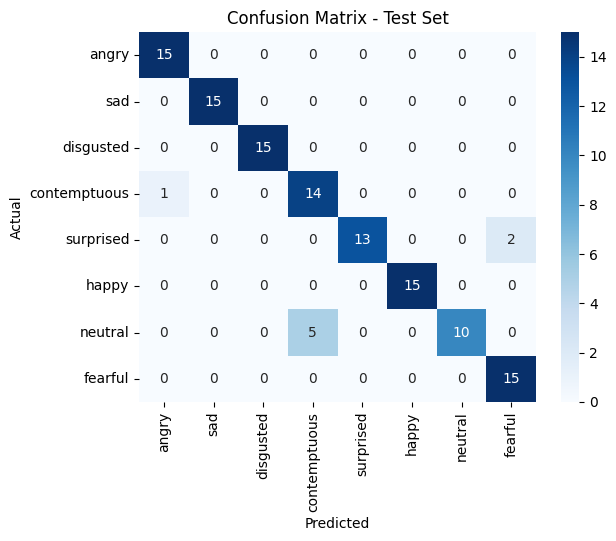

In [ ]:
# Assuming class_dict is a dictionary with class names as keys
class_names = list(class_dict.keys())

cf_matrix = cf.cpu().numpy()
# Create the heatmap with class names
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()